In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import time

In [2]:
import requests
import time
import random
import re
from bs4 import BeautifulSoup

# Lists to store scraped data
product_name = []
ratings = []
inverter_list = []
stabilizer_list = []
warranty_list = []
prod_price = []

# Sample patterns (customize as needed)
inverter_pattern =re.compile( r'\b(?:Smart|Digital|Normal|Reciprocating)\s+Inverter(?:\s+Compressor)?|\b(?:Normal|Reciprocating)\s+Compressor\b',
    re.IGNORECASE)
stabilizer_pattern = re.compile(r'\bBuilt[-\s]*in\s+Stabilizer\b', re.IGNORECASE)
warranty_pattern =re.compile(  r'\b(?:\d+\+?\s*Years?\s*(?:on\s+\w+(?:\s+\w+)?(?:,)?\s*)?)+(?:from\s+\w+)?\b',
    re.IGNORECASE)


# User-Agent list for rotation
user_agents = [
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/138.0.0.0 Safari/537.36',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/137.0.0.0 Safari/537.36',
    'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/136.0.0.0 Safari/537.36'
]

for page in range(1, 7):
    # Rotate user agent
    request_header = {
        'Content-Type': 'application/json',
        'User-Agent': random.choice(user_agents),
        'Accept-Encoding': 'gzip, deflate, br, zstd'
    }

    url = f"https://www.flipkart.com/search?q=refrigerator+double+door&page={page}"
    
    success = False
    retries = 3  # Try up to 3 times if 429 received

    for attempt in range(retries):
        response = requests.get(url, headers=request_header)

        if response.status_code == 200:
            print(f"Page {page} Status Code: 200 ")
            success = True
            break
        else:
            print(f"Page {page} attempt {attempt+1}: Status Code {response.status_code}")
            time.sleep(random.randint(5, 8))  # Wait longer before retry

    if not success:
        print(f"Skipping Page {page} after {retries} failed attempts ")
        continue

    soup = BeautifulSoup(response.text, 'html.parser')

    # Product names
    prod = soup.find_all("div", class_="KzDlHZ")
    for i in prod:
        product_name.append(i.text.strip())

    # Ratings
    for rating in soup.find_all("div", class_="_5OesEi"):
        raw_text = rating.text.replace('\xa0', ' ').strip()
        match = re.search(r'([\d.]+)[^\d]+([\d,]+)\s*Ratings[^\d]+([\d,])', raw_text)
        if match:
            rating_val = float(match.group(1))
            ratings.append(rating_val)
        else:
            ratings.append(None)

    # Specs
    for div in soup.find_all("div", class_="_6NESgJ"):
        text = div.get_text(separator=' ').strip()
        inverter = inverter_pattern.search(text)
        stabilizer = stabilizer_pattern.search(text)
        warranty = warranty_pattern.search(text)

        inverter_list.append(inverter.group().strip() if inverter else "")
        stabilizer_list.append(stabilizer.group().strip() if stabilizer else "")
        warranty_list.append(warranty.group().strip() if warranty else "")

    # Prices
    prices = soup.find_all("div", class_="Nx9bqj _4b5DiR")
    for price in prices:
        prod_price.append(price.text.strip())

    # Be respectful to Flipkart server
    time.sleep(random.randint(3, 6))  # Sleep randomly between 3–6 seconds


Page 1 Status Code: 200 
Page 2 Status Code: 200 
Page 3 Status Code: 200 
Page 4 attempt 1: Status Code 429
Page 4 Status Code: 200 
Page 5 Status Code: 200 
Page 6 attempt 1: Status Code 429
Page 6 attempt 2: Status Code 429
Page 6 Status Code: 200 


# EDA

In [3]:
min_len = min(len(product_name), len(inverter_list),len(stabilizer_list),
              len(warranty_list), len(ratings),len(prod_price))

df = pd.DataFrame({
    "product_name": product_name[:min_len],
    "inverter": inverter_list[:min_len],
    "Stabilizer":stabilizer_list[:min_len],
    "Warranty": warranty_list[:min_len],
    "Ratings": ratings[:min_len],
    "prod_price": prod_price[:min_len]
})


In [4]:
df

,product_name,inverter,Stabilizer,Warranty,Ratings,prod_price
0,Samsung 301 L Frost Free Double Door 3 Star Co...,Reciprocating Compressor,Built-in Stabilizer,1 Year,4.311,"₹34,990"
1,Samsung 350 L Frost Free Double Door 3 Star Co...,Reciprocating Compressor,Built-in Stabilizer,1 Year,4.311,"₹40,490"
2,Samsung 236 L Frost Free Double Door 3 Star Co...,Digital Inverter Compressor,Built-in Stabilizer,1 year,4.426,"₹25,990"
3,Samsung 301 L Frost Free Double Door 3 Star Co...,Reciprocating Compressor,Built-in Stabilizer,1 year,4.311,"₹35,490"
4,Whirlpool 235 L Frost Free Double Door 2 Star ...,Reciprocating Compressor,Built-in Stabilizer,1 Year,4.270,"₹22,990"
...,...,...,...,...,...,...
135,Hitachi 403 L Frost Free Double Door 2 Star Re...,,Built-in Stabilizer,1 Year,4.210,"₹47,561"
136,Voltas Beko 283 L Frost Free Double Door 2 Sta...,Smart Inverter Compressor,Built-in Stabilizer,1 Year on Product,4.000,"₹24,990"
137,Voltas Beko by A Tata Product 228 L Frost Free...,Smart Inverter Compressor,Built-in Stabilizer,1 Year,4.210,"₹21,990"
138,Voltas Beko by A Tata Product 228 L Frost Free...,Smart Inverter Compressor,Built-in Stabilizer,1 Year,4.311,"₹39,999"


In [5]:
df.to_csv("Flipkart_refrigerators_Specs.csv", index=False)

In [6]:
df1 = pd.read_csv("Flipkart_refrigerators_Specs.csv")

In [7]:
df1.head()

,product_name,inverter,Stabilizer,Warranty,Ratings,prod_price
0,Samsung 301 L Frost Free Double Door 3 Star Co...,Reciprocating Compressor,Built-in Stabilizer,1 Year,4.311,"₹34,990"
1,Samsung 350 L Frost Free Double Door 3 Star Co...,Reciprocating Compressor,Built-in Stabilizer,1 Year,4.311,"₹40,490"
2,Samsung 236 L Frost Free Double Door 3 Star Co...,Digital Inverter Compressor,Built-in Stabilizer,1 year,4.426,"₹25,990"
3,Samsung 301 L Frost Free Double Door 3 Star Co...,Reciprocating Compressor,Built-in Stabilizer,1 year,4.311,"₹35,490"
4,Whirlpool 235 L Frost Free Double Door 2 Star ...,Reciprocating Compressor,Built-in Stabilizer,1 Year,4.270,"₹22,990"


In [8]:
df1.inverter.value_counts()

inverter
Reciprocating Compressor       48
Smart Inverter Compressor      29
Digital Inverter Compressor     9
Smart Inverter                  6
Normal Compressor               2
Digital Inverter                1
Name: count, dtype: int64

In [9]:
df1.Stabilizer.value_counts()

Stabilizer
Built-in Stabilizer    138
Name: count, dtype: int64

In [10]:
df1.product_name.value_counts()

product_name
Voltas Beko by A Tata Product 228 L Frost Free Double Door 3 Star Refrigerator                               12
Samsung 350 L Frost Free Double Door 3 Star Convertible Refrigerator  with 5-in-1, Digital Inverter, W...     7
Voltas Beko by A Tata Product 228 L Frost Free Double Door 2 Star Refrigerator                                7
Samsung 301 L Frost Free Double Door 3 Star Convertible Refrigerator                                          6
Samsung 330 L Frost Free Double Door 2 Star Convertible Refrigerator  with 5-in-1, Digital Inverter, W...     6
                                                                                                             ..
Godrej 272 L Frost Free Double Door 3 Star Convertible Refrigerator  with Freezer 95%+ Food Surface Di...     1
Whirlpool 308 L Frost Free Double Door 3 Star Convertible Refrigerator  with 3 Star Convertible               1
BOSCH 415 L Frost Free Double Door 3 Star Refrigerator                                     

In [11]:
df1['prod_price']=df1['prod_price'].str.replace("₹"," ")

In [12]:
df

,product_name,inverter,Stabilizer,Warranty,Ratings,prod_price
0,Samsung 301 L Frost Free Double Door 3 Star Co...,Reciprocating Compressor,Built-in Stabilizer,1 Year,4.311,"₹34,990"
1,Samsung 350 L Frost Free Double Door 3 Star Co...,Reciprocating Compressor,Built-in Stabilizer,1 Year,4.311,"₹40,490"
2,Samsung 236 L Frost Free Double Door 3 Star Co...,Digital Inverter Compressor,Built-in Stabilizer,1 year,4.426,"₹25,990"
3,Samsung 301 L Frost Free Double Door 3 Star Co...,Reciprocating Compressor,Built-in Stabilizer,1 year,4.311,"₹35,490"
4,Whirlpool 235 L Frost Free Double Door 2 Star ...,Reciprocating Compressor,Built-in Stabilizer,1 Year,4.270,"₹22,990"
...,...,...,...,...,...,...
135,Hitachi 403 L Frost Free Double Door 2 Star Re...,,Built-in Stabilizer,1 Year,4.210,"₹47,561"
136,Voltas Beko 283 L Frost Free Double Door 2 Sta...,Smart Inverter Compressor,Built-in Stabilizer,1 Year on Product,4.000,"₹24,990"
137,Voltas Beko by A Tata Product 228 L Frost Free...,Smart Inverter Compressor,Built-in Stabilizer,1 Year,4.210,"₹21,990"
138,Voltas Beko by A Tata Product 228 L Frost Free...,Smart Inverter Compressor,Built-in Stabilizer,1 Year,4.311,"₹39,999"


In [13]:
df1['prod_price']=df1['prod_price'].str.replace(",","").astype(float)

In [14]:
df1

,product_name,inverter,Stabilizer,Warranty,Ratings,prod_price
0,Samsung 301 L Frost Free Double Door 3 Star Co...,Reciprocating Compressor,Built-in Stabilizer,1 Year,4.311,34990.0
1,Samsung 350 L Frost Free Double Door 3 Star Co...,Reciprocating Compressor,Built-in Stabilizer,1 Year,4.311,40490.0
2,Samsung 236 L Frost Free Double Door 3 Star Co...,Digital Inverter Compressor,Built-in Stabilizer,1 year,4.426,25990.0
3,Samsung 301 L Frost Free Double Door 3 Star Co...,Reciprocating Compressor,Built-in Stabilizer,1 year,4.311,35490.0
4,Whirlpool 235 L Frost Free Double Door 2 Star ...,Reciprocating Compressor,Built-in Stabilizer,1 Year,4.270,22990.0
...,...,...,...,...,...,...
135,Hitachi 403 L Frost Free Double Door 2 Star Re...,NaN,Built-in Stabilizer,1 Year,4.210,47561.0
136,Voltas Beko 283 L Frost Free Double Door 2 Sta...,Smart Inverter Compressor,Built-in Stabilizer,1 Year on Product,4.000,24990.0
137,Voltas Beko by A Tata Product 228 L Frost Free...,Smart Inverter Compressor,Built-in Stabilizer,1 Year,4.210,21990.0
138,Voltas Beko by A Tata Product 228 L Frost Free...,Smart Inverter Compressor,Built-in Stabilizer,1 Year,4.311,39999.0


In [15]:
##to check the numerical
df1.describe()

,Ratings,prod_price
count,139.000000,140.000000
mean,4.449676,31015.228571
std,3.136657,8913.754092
min,3.000000,18490.000000
25%,4.210000,22990.000000
50%,4.240000,27840.000000
75%,4.311000,36990.000000
max,41.000000,55000.000000


In [16]:
##To check the columns along with object type
df1.describe(include="object")

,product_name,inverter,Stabilizer,Warranty
count,140,95,138,140
unique,75,6,1,12
top,Voltas Beko by A Tata Product 228 L Frost Free...,Reciprocating Compressor,Built-in Stabilizer,1 Year
freq,12,48,138,105


In [17]:
df1.isnull().sum()

product_name     0
inverter        45
Stabilizer       2
Warranty         0
Ratings          1
prod_price       0
dtype: int64

In [18]:
print(df1["product_name"].unique())

['Samsung 301 L Frost Free Double Door 3 Star Convertible Refrigerator'
 'Samsung 350 L Frost Free Double Door 3 Star Convertible Refrigerator  with 5-in-1, Digital Inverter, W...'
 'Samsung 236 L Frost Free Double Door 3 Star Convertible Refrigerator  with Digital Inverter and Displa...'
 'Samsung 301 L Frost Free Double Door 3 Star Convertible Refrigerator  with Digital Inverter, Convertib...'
 'Whirlpool 235 L Frost Free Double Door 2 Star Refrigerator'
 'Samsung 236 L Frost Free Double Door 2 Star Refrigerator  with Digital Inverter'
 'Voltas Beko by A Tata Product 228 L Frost Free Double Door 3 Star Refrigerator'
 'LG 242 L Frost Free Double Door 3 Star Refrigerator  with DoorCooling+ & Smart Inverter Compressor'
 'LG 272 L Frost Free Double Door 3 Star Convertible Refrigerator  with Inverter Compressor, Express Fre...'
 'Voltas Beko by A Tata Product 228 L Frost Free Double Door 2 Star Refrigerator'
 'Godrej 244 L Frost Free Double Door 4 Star Convertible Refrigerator  with 6-In-

In [19]:
print(df1["inverter"].unique())

['Reciprocating Compressor' 'Digital Inverter Compressor'
 'Smart Inverter Compressor' 'Smart Inverter' nan 'Normal Compressor'
 'Digital Inverter']


In [20]:
print(df1["Stabilizer"].unique())

['Built-in Stabilizer' nan]


In [21]:
print(df1["Warranty"].unique())

['1 Year' '1 year' '1 Year on Product and 10 Years on Compressor from'
 '1 Year on Product' '1 Year on Product and 10 Years on Compressor From'
 '4 years' '1 Years' '1 Year on Product and 10 Years on Compressor'
 '3 Year' '2 Years' '1 Year on Product and 10 Years on Compressor Fro'
 '1 Year on Unit and 10 Years on Compressor From']


In [22]:
df1["Stabilizer"]=df1["Stabilizer"].fillna(df1["Stabilizer"].mode()[0])

In [23]:
df1["inverter"]=df1["inverter"].fillna(df1["inverter"].mode()[0])

In [24]:
df1["Warranty"]=df1["Warranty"].fillna(df1["Warranty"].mode()[0])

In [25]:
df1["product_name"]=df1["product_name"].fillna(df1["product_name"].mode()[0])

In [26]:
df1["prod_price"]=df1["prod_price"].fillna(df1["prod_price"].mode()[0])

In [27]:
df1["Ratings"]=df1["Ratings"].fillna(df1["Ratings"].mode()[0])

In [28]:
df1.isnull().sum()

product_name    0
inverter        0
Stabilizer      0
Warranty        0
Ratings         0
prod_price      0
dtype: int64

In [29]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   product_name  140 non-null    object 
 1   inverter      140 non-null    object 
 2   Stabilizer    140 non-null    object 
 3   Warranty      140 non-null    object 
 4   Ratings       140 non-null    float64
 5   prod_price    140 non-null    float64
dtypes: float64(2), object(4)
memory usage: 6.7+ KB


In [30]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   product_name  140 non-null    object 
 1   inverter      140 non-null    object 
 2   Stabilizer    140 non-null    object 
 3   Warranty      140 non-null    object 
 4   Ratings       140 non-null    float64
 5   prod_price    140 non-null    float64
dtypes: float64(2), object(4)
memory usage: 6.7+ KB


## DATA VISUALIZATION USING DOUBLE DOOR REFRIDGERATORS IN FILPKART

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")


In [36]:
df

,product_name,inverter,Stabilizer,Warranty,Ratings,prod_price
0,Samsung 301 L Frost Free Double Door 3 Star Co...,Reciprocating Compressor,Built-in Stabilizer,1 Year,4.311,"₹34,990"
1,Samsung 350 L Frost Free Double Door 3 Star Co...,Reciprocating Compressor,Built-in Stabilizer,1 Year,4.311,"₹40,490"
2,Samsung 236 L Frost Free Double Door 3 Star Co...,Digital Inverter Compressor,Built-in Stabilizer,1 year,4.426,"₹25,990"
3,Samsung 301 L Frost Free Double Door 3 Star Co...,Reciprocating Compressor,Built-in Stabilizer,1 year,4.311,"₹35,490"
4,Whirlpool 235 L Frost Free Double Door 2 Star ...,Reciprocating Compressor,Built-in Stabilizer,1 Year,4.270,"₹22,990"
...,...,...,...,...,...,...
135,Hitachi 403 L Frost Free Double Door 2 Star Re...,,Built-in Stabilizer,1 Year,4.210,"₹47,561"
136,Voltas Beko 283 L Frost Free Double Door 2 Sta...,Smart Inverter Compressor,Built-in Stabilizer,1 Year on Product,4.000,"₹24,990"
137,Voltas Beko by A Tata Product 228 L Frost Free...,Smart Inverter Compressor,Built-in Stabilizer,1 Year,4.210,"₹21,990"
138,Voltas Beko by A Tata Product 228 L Frost Free...,Smart Inverter Compressor,Built-in Stabilizer,1 Year,4.311,"₹39,999"


## visualizing the categorical data such as inverter and stabilizer

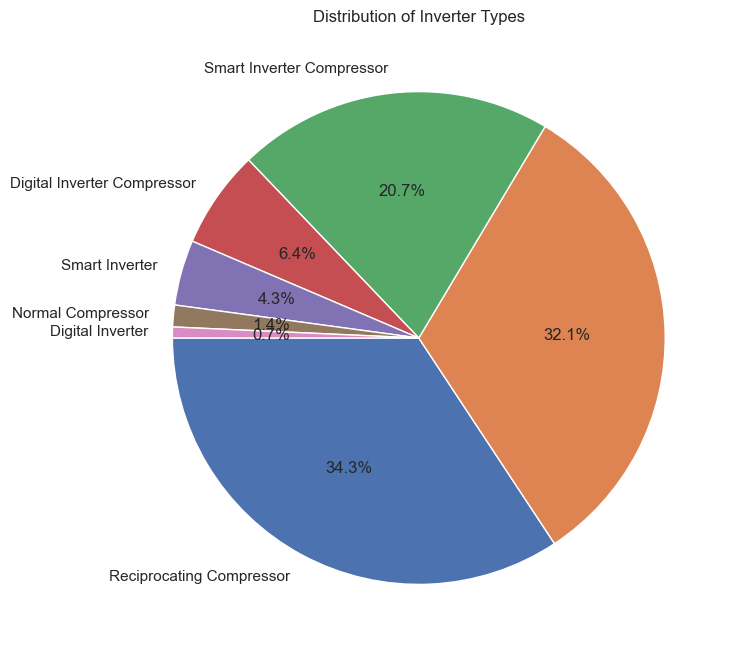

In [42]:
plt.figure(figsize=(10, 8))
df['inverter'].value_counts().plot.pie(autopct='%1.1f%%', startangle=180)
plt.title("Distribution of Inverter Types")
plt.ylabel('')
plt.show()

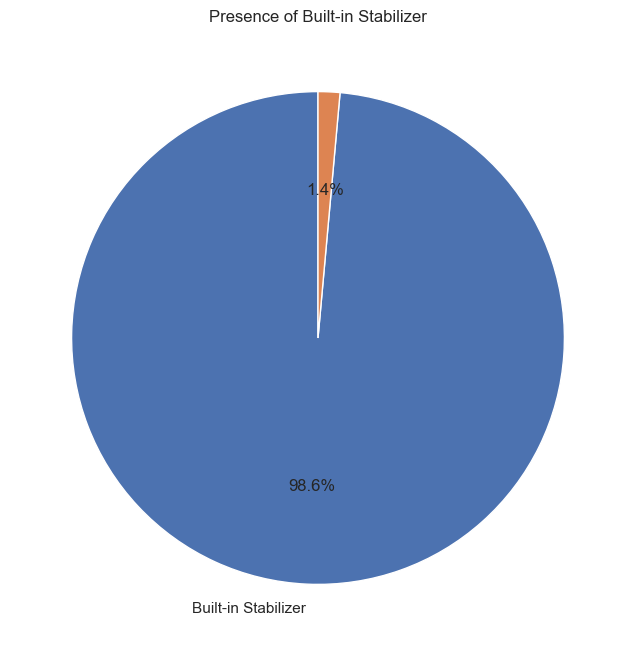

In [43]:
plt.figure(figsize=(10, 8))
df['Stabilizer'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title("Presence of Built-in Stabilizer")
plt.ylabel('')
plt.show()


## univariant analysis of ratings and prices

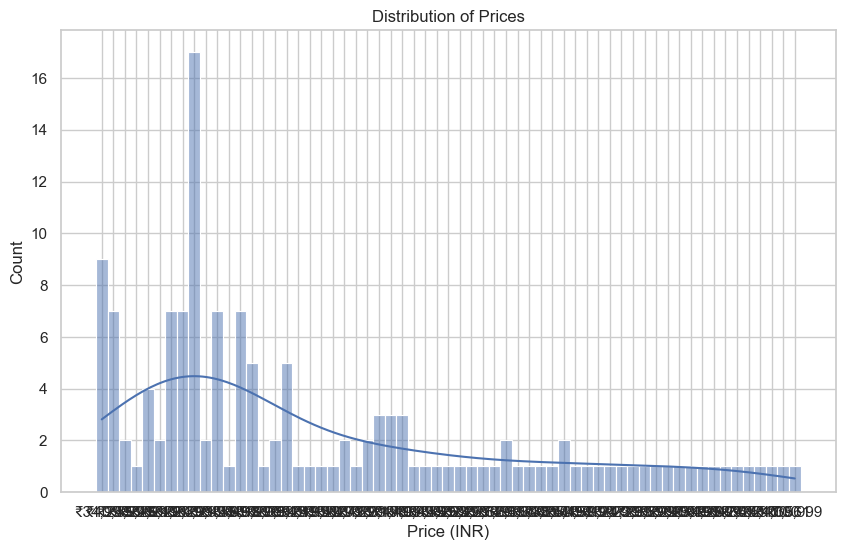

In [44]:
sns.histplot(df['prod_price'], bins=5, kde=True)
plt.title("Distribution of Prices")
plt.xlabel("Price (INR)")
plt.show()

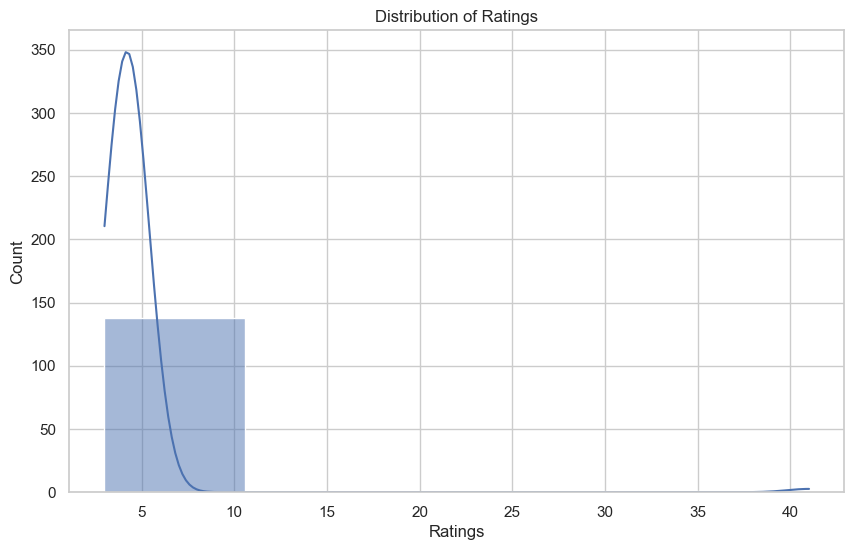

In [45]:
sns.histplot(df['Ratings'], bins=5, kde=True)
plt.title("Distribution of Ratings")
plt.xlabel("Ratings")
plt.show()

##  categorical v/s numerical 

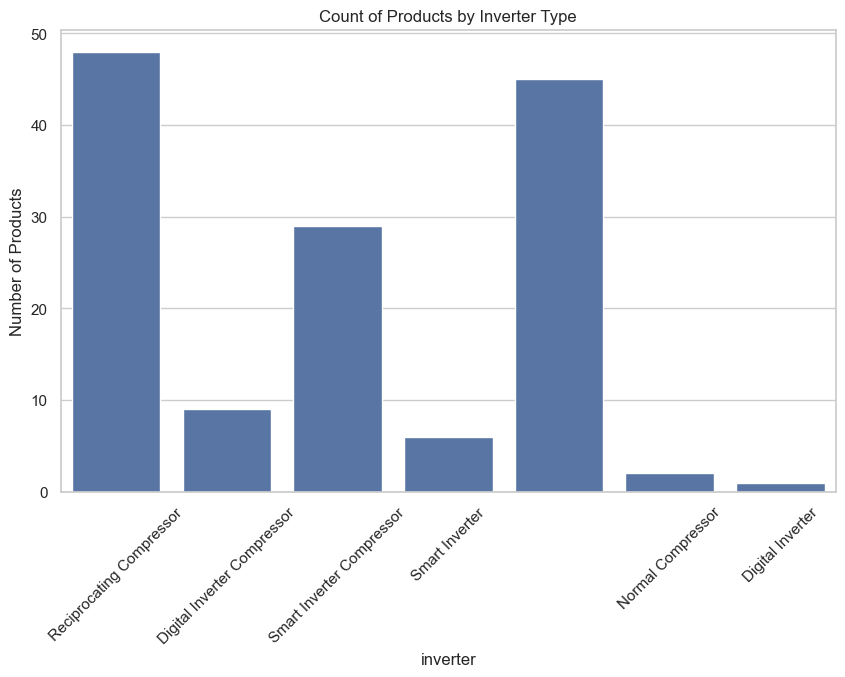

In [48]:
sns.countplot(x='inverter', data=df)
plt.title("Count of Products by Inverter Type")
plt.xticks(rotation=45)
plt.ylabel("Number of Products")
plt.show()

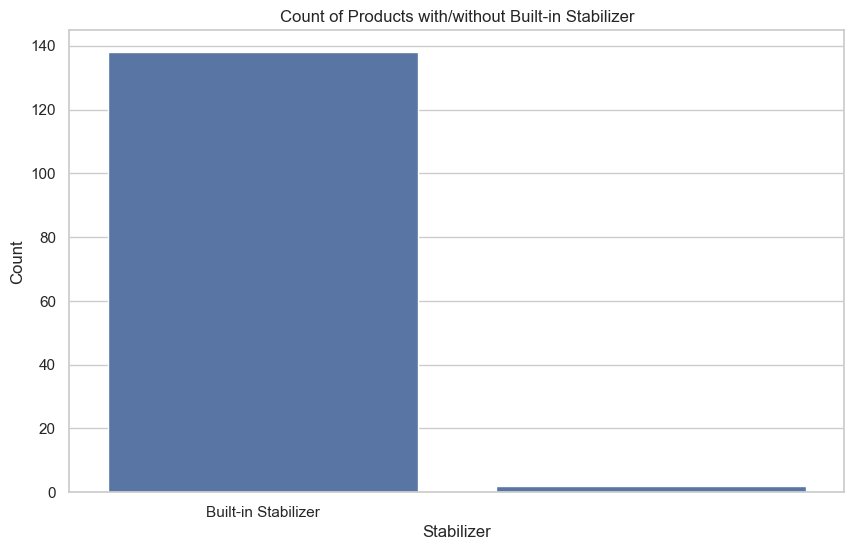

In [49]:
sns.countplot(x='Stabilizer', data=df)
plt.title("Count of Products with/without Built-in Stabilizer")
plt.ylabel("Count")
plt.show()

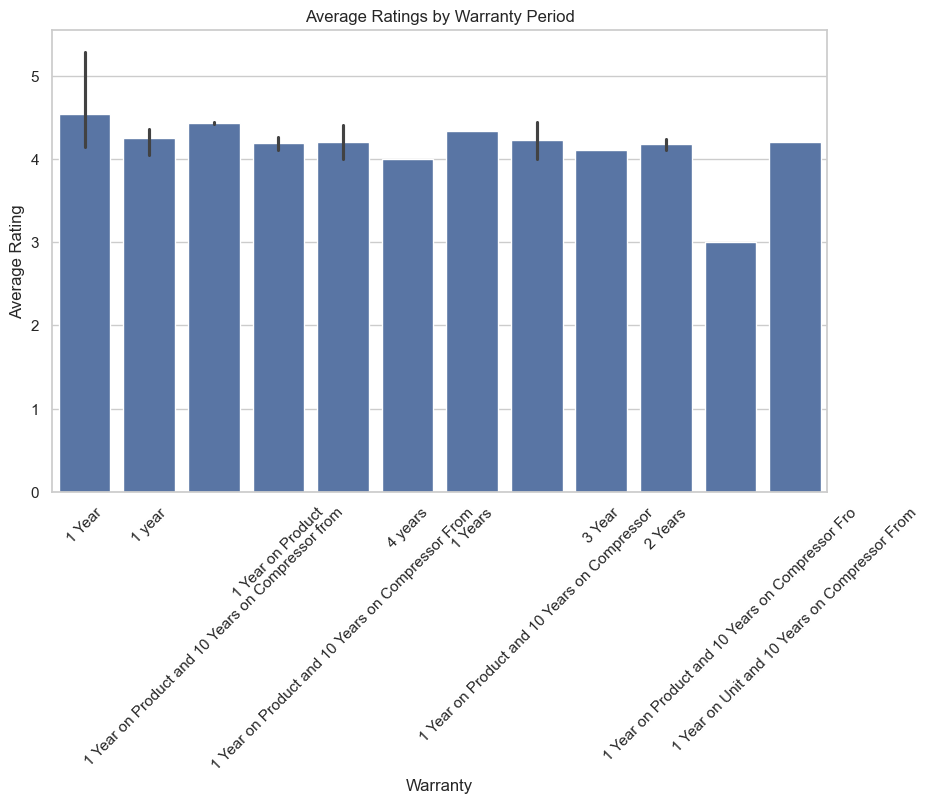

In [51]:
## average rating by warranty cateogry
sns.barplot(x='Warranty', y='Ratings', data=df, estimator='mean')
plt.title("Average Ratings by Warranty Period")
plt.xticks(rotation=45)
plt.ylabel("Average Rating")
plt.show()


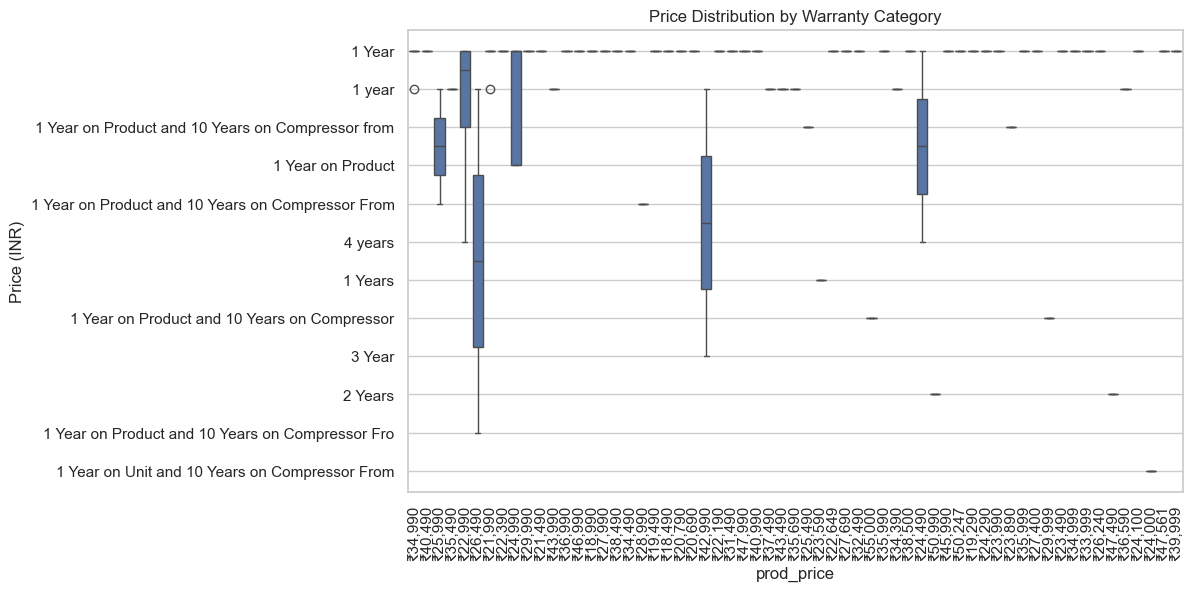

In [58]:
## price by warranty
sns.boxplot(x='prod_price', y='Warranty', data=df)
plt.title("Price Distribution by Warranty Category")
plt.xticks(rotation=90)
plt.ylabel("Price (INR)")
plt.show()

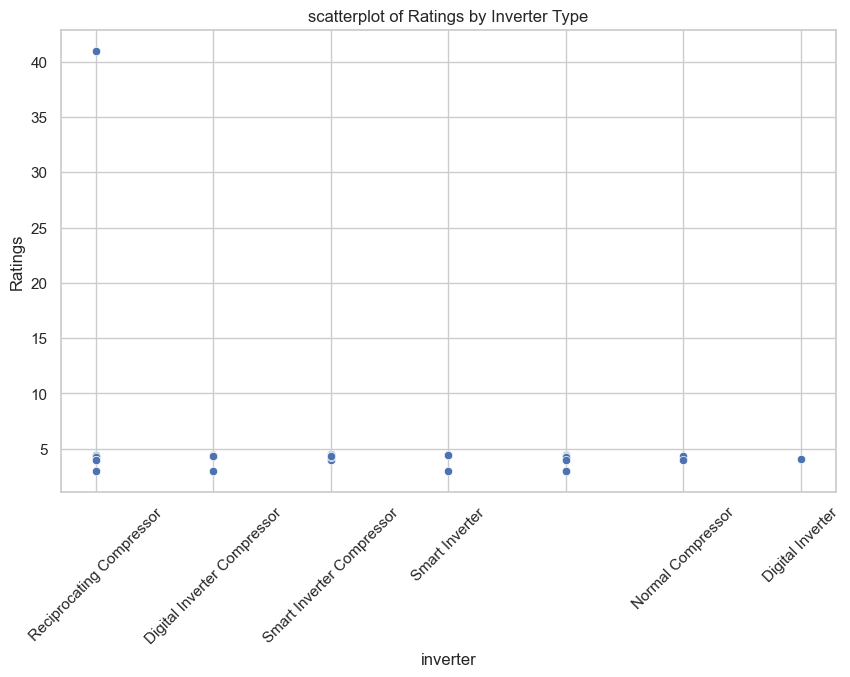

In [63]:
sns.scatterplot(x='inverter', y='Ratings', data=df)
plt.title("scatterplot of Ratings by Inverter Type")
plt.xticks(rotation=45)
plt.show()


## COMBO CHART INVERTER STABILIZER

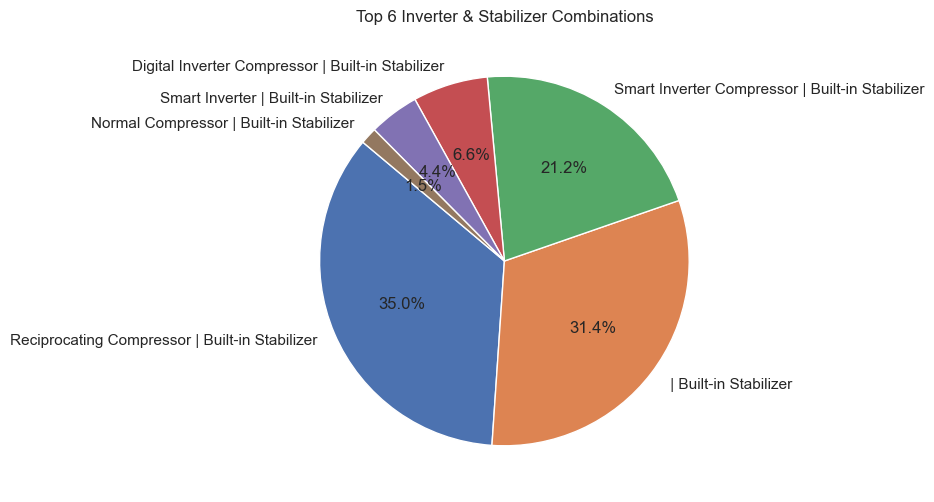

In [65]:
df['Inverter_Stabilizer'] = df['inverter'] + " | " + df['Stabilizer'].replace('', 'No Stabilizer')
df['Inverter_Stabilizer'].value_counts().nlargest(6).plot.pie(autopct='%1.1f%%', startangle=140)
plt.title("Top 6 Inverter & Stabilizer Combinations")
plt.ylabel('')
plt.show()


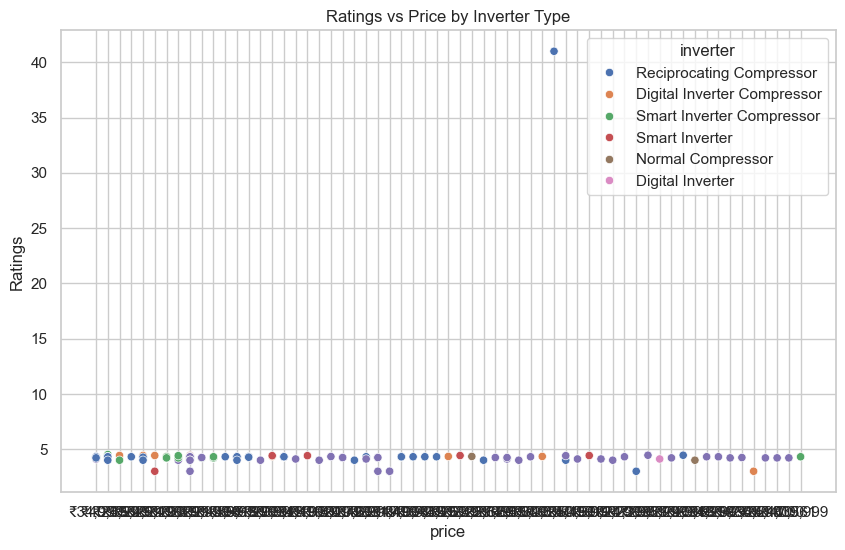

In [68]:
sns.scatterplot(x='prod_price', y='Ratings', hue='inverter', data=df)
plt.title("Ratings vs Price by Inverter Type")
plt.xlabel("price")
plt.ylabel("Ratings")
plt.show()

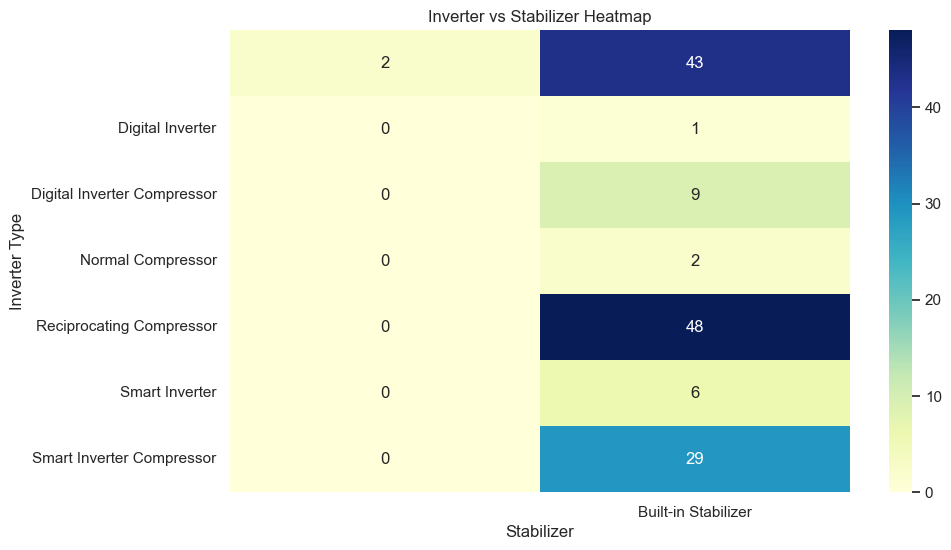

In [69]:
crosstab = pd.crosstab(df['inverter'], df['Stabilizer'])
sns.heatmap(crosstab, annot=True, cmap="YlGnBu", fmt="d")
plt.title("Inverter vs Stabilizer Heatmap")
plt.ylabel("Inverter Type")
plt.xlabel("Stabilizer")
plt.show()


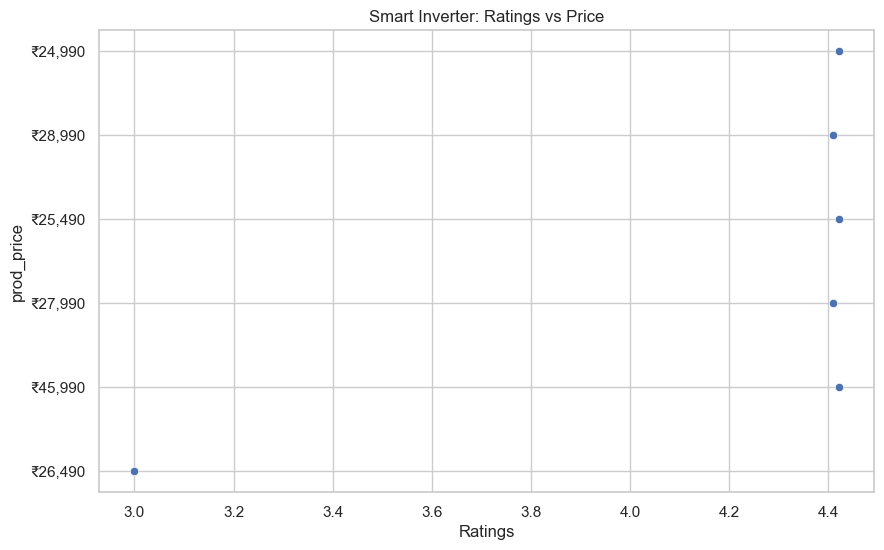

In [75]:
## Scatter 4: Smart Inverter only
smart_df = df[df['inverter'] == 'Smart Inverter']
sns.scatterplot(data=smart_df, x='Ratings', y='prod_price')
plt.title("Smart Inverter: Ratings vs Price")
plt.show()